# Electron Backscatter Diffraction (EBSD) analysis of polycrystalline Nickel

The goal of EBSD analysis is often to determine the crystal orientation from each EBSD pattern, typically called *indexing*. One approach is dictionary indexing, first described in Chen et al. (2015) ([doi](https://doi.org/10.1017/S1431927615000756)). Here we'll demonstrate how to do this in [kikuchipy](https://kikuchipy.org). The implementation is based on the one in EMsoft, as described in Jackson et al. (2017) ([doi](https://doi.org/10.1007/s40192-019-00137-4)).

Dictionary indexing is not as tried and tested as the commonly used Hough indexing. To aid the evaluation of dictionary indexing results, we therefore first obtain several maps to get an overview of the quality of the EBSD patterns and the features in the region of interest before indexing, independent of any bias introdued in indexing. After indexing, we'll also inspect the results visually using dynamical and geometrical EBSD simulations.

The following links might be useful:
* User guide with notebooks, reference to all classes and functions, and more: https://kikuchipy.org
* Source code, issue tracker, and more: https://github.com/pyxem/kikuchipy
* Chat or discussions: https://gitter.im/pyxem/kikuchipy or https://github.com/pyxem/kikuchipy/discussions

### Author
* 29/7/2021 Håkon Wiik Ånes - Written for M&M 2021 Sunday Short Course *X-15 Data Analysis in Materials Science*

### Requirements
* kikuchipy 0.4

## <a id='toc'>Table of contents</a>
1. <a href='#1'>Load and view data</a>
2. <a href='#2'>Pre-pattern-processing maps</a>
3. <a href='#3'>Process pattern intensities</a>
4. <a href='#4'>Pre-indexing maps</a>
5. <a href='#5'>Dictionary indexing</a>
6. <a href='#6'>Inspect indexing results</a>
7. <a href='#7'>Going further</a>

# <a id='1'>1. Load and view data</a>

<a href='#toc'>Table of contents</a>

Set Matplotlib plotting backend and import packages

In [1]:
%matplotlib inline
# Other backends:
# * qt5: interactive plotting locally, from the pyqt package which might have to be installed separately
# * notebook: interactive plotting in Binder

import hyperspy.api as hs
import matplotlib.pyplot as plt

# pyxem family of packages (except pyxem)
from diffsims.crystallography import ReciprocalLatticePoint
import kikuchipy as kp
from orix import io, quaternion, sampling, vector

Load (and download) an EBSD dataset of polycrystalline, recrystallized Nickel which is part of the `kikuchipy.data` module ("large" = 13 MB, compared to "small" < 1 MB).

In [2]:
s = kp.data.nickel_ebsd_large(allow_download=True)
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

Inspect the navigation and signal dimensions (more closely) in the `axes_manager`

In [3]:
s.axes_manager

<Axes manager, axes: (75, 55|60, 60)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     75 |      0 |       0 |     1.5 |     um 
               y |     55 |      0 |       0 |     1.5 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     60 |        |       0 |       1 |     um 
              dy |     60 |        |       0 |       1 |     um

Plot the data (by navigating the patterns in a mean intensity map) with `plot()`

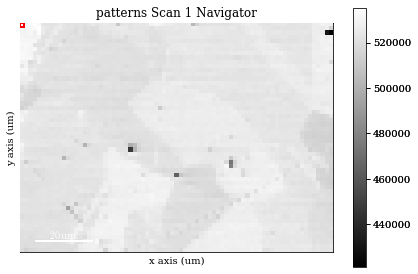

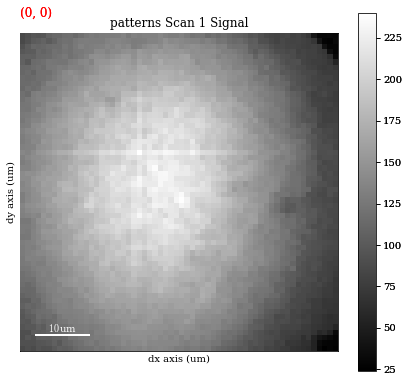

In [4]:
s.plot()

Note that `kikuchipy` has a `kikuchipy.load()` function almost identical to `hyperspy.api.load()`, which can read several commercial EBSD formats. See the [IO user guide](https://kikuchipy.org/en/latest/load_save_data.html) for more information.

# <a id='2'>2. Pre-pattern-processing maps</a>

<a href='#toc'>Table of contents</a>

## Mean intensity in each pattern

Get the map of the mean intensity in each pattern with `mean()`

In [5]:
mean_intensity = s.mean(axis=(2, 3))
mean_intensity

<BaseSignal, title: patterns Scan 1, dimensions: (75, 55|)>

Plot the mean intensity map

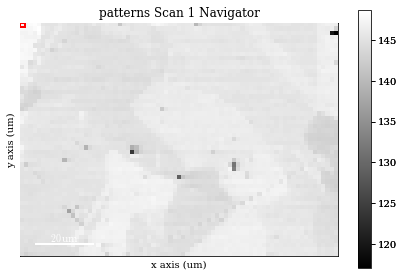

In [6]:
mean_intensity.plot()

## Virtual backscatter electron (VBSE) images

Inspect angle resolved backscatter electron (BSE) images, typically called VBSE/vBSE/virtual diode imaging.

Create a `VirtualBSEGenerator`

In [7]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)
vbse_gen

VirtualBSEGenerator for <EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

### One image per VBSE grid tile

Separate the EBSD detector (signal dimensions) into a (3 x 3) grid by setting `grid_shape`

In [8]:
vbse_gen.grid_shape = (3, 3)

Plot the grid with `plot_grid()`

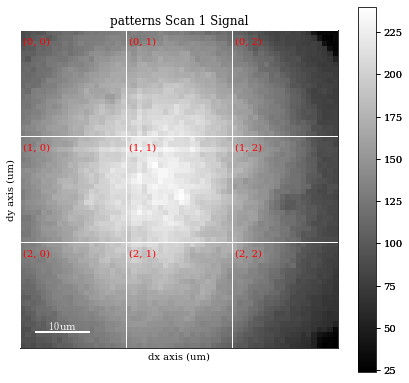

In [9]:
vbse_gen.plot_grid();

Get one VBSE image from the intensity within each grid tile with `get_images_from_grid()`

In [10]:
vbse_imgs = vbse_gen.get_images_from_grid()
vbse_imgs

<VirtualBSEImage, title: , dimensions: (3, 3|75, 55)>

Plot the images (one by one)

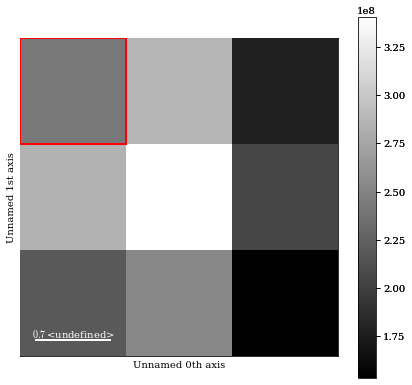

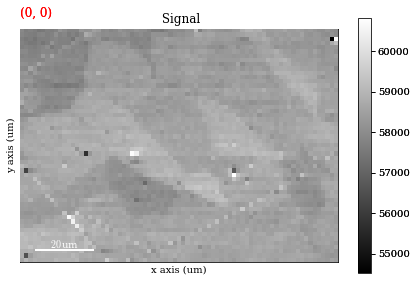

In [11]:
vbse_imgs.plot()

Strech the image contrast in each VBSE image by setting the darkest intensities to 0 and the highest intensities to 255 within the 0.5% percentiles, using `rescale_intensity()`

In [12]:
vbse_imgs.rescale_intensity(percentiles=(0.5, 99.5))

Rescaling the image intensities:
[########################################] | 100% Completed |  0.6s


Replot the images after intensity rescaling in a nice image grid using HyperSpy's `plot_images()`

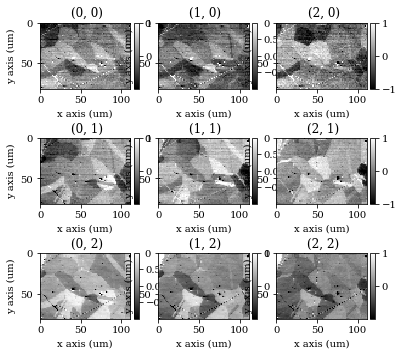

In [13]:
hs.plot.plot_images(vbse_imgs);

### RGB image

Separate the EBSD detector into a (5 x 5) grid

In [14]:
vbse_gen.grid_shape = (5, 5)

Set some (can be more than one) of the grid tiles to be coloured red, green, or blue, and plot the color key

<EBSD, title: patterns Scan 1, dimensions: (|60, 60)>

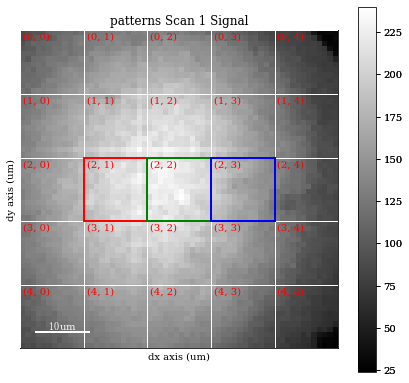

In [15]:
rgb = [(2, 1), (2, 2), (2, 3)]
vbse_gen.plot_grid(rgb_channels=rgb)

Create an RGB image from the specified grid tiles with `get_rgb_image()`

In [16]:
vbse_rgb_img = vbse_gen.get_rgb_image(*rgb)
vbse_rgb_img

<VirtualBSEImage, title: , dimensions: (|75, 55)>

Plot the resulting image

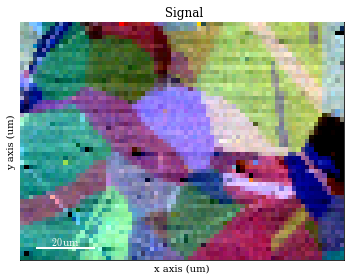

In [17]:
vbse_rgb_img.plot()

# <a id='3'>3. Process pattern intensities</a>

<a href='#toc'>Table of contents</a>

The raw EBSD signal can be empirically evaluated as a superposition of a Kikuchi diffraction pattern and a smooth background intensity. For pattern indexing, the latter intensity is usually undesirable, while for VBSE imaging, as we saw above, this intensity can reveal topographical, compositional or diffraction contrast.

## Remove the static background

Effects which are constant, like hot pixels or dirt on the detector, can be removed by either subtracting or dividing by a static background. Ideally, this background pattern has no signal of interest.

A static background pattern was acquired with the Nickel EBSD data set, which was loaded with the data set into the signal metadata.

Retrieve this background from the `metadata` and plot it

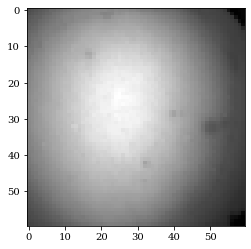

In [18]:
bg = s.metadata.Acquisition_instrument.SEM.Detector.EBSD.static_background

fig, ax = plt.subplots()
ax.imshow(bg, cmap="gray")

If one is not available, we can try to generate a suitable static background by averaging all patterns (and reverting the data type to 8-bit unsigned integers)

In [19]:
bg2 = s.mean(axis=(0, 1))
bg2.change_dtype(s.data.dtype)

Compare it to the background from the metadata by plotting it

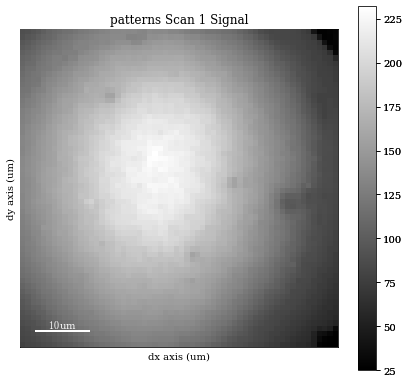

In [20]:
bg2.plot()

Remove the static background with `remove_static_background()`

In [21]:
s.remove_static_background()

Removing the static background:
[########################################] | 100% Completed |  0.4s


## Remove the dynamic background

Uneven intensity in a static background subtracted pattern can be corrected by subtracting or dividing by a dynamic background obtained by Gaussian blurring. A Gaussian window with a standard deviation set by `std` is used to blur each pattern individually (dynamic) either in the spatial or frequency domain. Blurring in the frequency domain is effectively accomplished by a low-pass Fast Fourier Transform (FFT) filter. The individual Gaussian blurred dynamic backgrounds are then subtracted or divided from the respective patterns.

Remove the dynamic background with `remove_dynamic_background()`

In [22]:
s.remove_dynamic_background()

Removing the dynamic background:
[########################################] | 100% Completed |  1.6s


## Average neighbour patterns

The signal-to-noise ratio in patterns can be improved by averaging patterns with their closest neighbours within a window/kernel/mask.

Let's average with all eight nearest neighbours, but use Gaussian weights with a standard deviation of 1. Create the Gaussian `filters.Window` and plot it

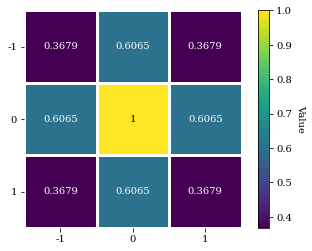

In [23]:
w = kp.filters.Window(window="gaussian", std=1)
w.plot()

Average all patterns with their neighbour patterns using the Gaussian window with `average_neighbour_patterns()`

In [24]:
s.average_neighbour_patterns(window=w)

Averaging with the neighbour patterns:
[########################################] | 100% Completed |  0.5s


We can subsequently save these patterns to `kikuchipy`'s own h5ebsd specification (see Jackson et al. (2014) ([doi](https://doi.org/10.1186/2193-9772-3-4)) for the general format). This format can be read back into kikuchipy, or as a file in the `EMEBSD` format in the powerful suite of [EMsoft](http://vbff.materials.cmu.edu/EMsoft/) command line programs.

In [25]:
#s.save("pattern_static_dynamic_averaged.h5")

Note that neighbour pattern averaging increases the virtual interaction volume of the electron beam with the sample, leading to a potential loss in spatial resolution. Averaging may in some cases, like on grain boundaries, mix two or more different diffraction patterns, which might be unwanted. See Wright et al. (2015) ([doi](https://doi.org/10.1016/j.ultramic.2015.08.001)) for a discussion of this concern.

# <a id='4'>4. Pre-indexing maps</a>

<a href='#toc'>Table of contents</a>

The image quality metric *Q* presented by Krieger Lassen ([PhD thesis](http://www.ebsd.info/pdf/PhD_KriegerLassen.pdf)) relies on the assumption that the sharper the Kikuchi bands, the greater the high frequency content of the FFT power spectrum, and thus the closer *Q* will be to unity. It can from this be expected that grain interiors will show a high *Q*, while grain boundaries will show a lower *Q*.

Get the image quality map with `get_image_quality()`

In [26]:
iq = s.get_image_quality()

Calculating the image quality:
[########################################] | 100% Completed |  1.3s


We can also produce a map showing how similar each pattern is to their four nearest neighbour (or any other number of neighbours specified by a binary mask). Get the average neighbour dot product map with `get_average_neighbour_dot_product_map()`

In [27]:
adp = s.get_average_neighbour_dot_product_map()

Calculating average neighbour dot product map:
[########################################] | 100% Completed |  1.3s


Let's plot them side by side with colorbars using `Matplotlib`

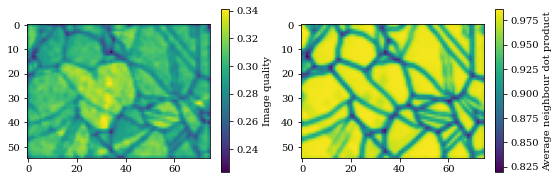

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))

im0 = ax[0].imshow(iq)
fig.colorbar(im0, ax=ax[0], label="Image quality")

im1 = ax[1].imshow(adp)
fig.colorbar(im1, ax=ax[1], label="Average neighbour dot product");

# <a id='5'>5. Dictionary indexing</a>

<a href='#toc'>Table of contents</a>

Now we're ready to set up and run dictionary indexing of the background corrected and averaged patterns.

## Load master pattern

Before we can generate a dictionary of simulated patterns, we need a dynamically simulated master pattern containing all possible scattering vectors for a candidate phase. This can be simulated using `EMsoft` (Callahan and De Graef, 2013, [doi](https://doi.org/10.1017/S1431927613001840)) and subsequently imported into kikuchipy using `kikuchipy.load()`.

For demonstration purposes, we've included small (401 x 401) master patterns of Nickel in the stereographic and Lambert (square) projections as part of the `kikuchipy.data` module. Load the 20 keV master pattern from the northern hemisphere in the Lambert projection

In [29]:
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy=20)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

Plot the master pattern

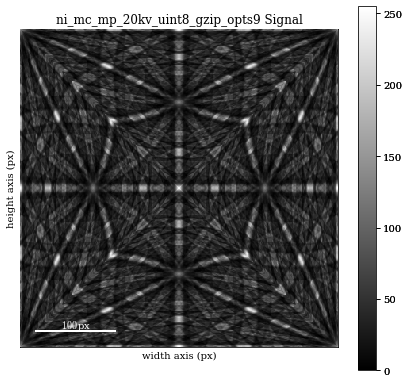

In [30]:
mp.plot()

Extract `phase` information loaded with the master pattern

In [31]:
phase = mp.phase
phase

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

Inspect it's crystal `structure` (list of asymmetric atom positions and a `structure.lattice`)

In [32]:
phase.structure

[28   0.000000 0.000000 0.000000 1.0000]

In [33]:
phase.structure.lattice

Lattice(a=0.35236, b=0.35236, c=0.35236, alpha=90, beta=90, gamma=90)

## Sample orientation space

Here we produce a sampling of the Rodriguez Fundamental Zone (RFZ) of point group $m\bar{3}m$ using a "characteristic distance" or "resolution" of 3$^{\circ}$, as implemented in [orix](https://orix.readthedocs.io). This resolution is quite coarse, and used here because of time and memory constraints. We, and EMsoft (see the aforementioned tutorial article by Jackson et al.), suggest using a smaller resolution of about 1.5$^{\circ}$ for experimental work.

Sample the RFZ for the Ni phase space group with a resolution of 3$^{\circ}$ using `orix.sampling.get_sample_fundamental()` and inspect the results

In [34]:
rot = sampling.get_sample_fundamental(
    resolution=3, space_group=phase.space_group.number
)
rot

Rotation (35083,)
[[ 1.     -0.     -0.     -0.    ]
 [ 0.9916 -0.1291 -0.     -0.    ]
 [ 0.9832 -0.1826 -0.     -0.    ]
 ...
 [ 0.9474 -0.3162 -0.      0.0497]
 [ 0.9386 -0.3416 -0.      0.0492]
 [ 0.9297 -0.3651 -0.      0.0487]]

## Define the sample-detector geometry

Now that we have our master pattern and crystal orientations, we need to describe the EBSD detector’s position with respect to the sample. This ensures that projecting parts of the master pattern onto our detector yields dynamically simulated patterns presumably resembling our experimental ones. The average projection/pattern center (PC) for this experiment was determined by indexing five calibration patterns using the EDAX TSL Data Collection v7 software, and is ($x^*$, $y^*$, $z^*$) = (0.4210, 0.7794, 0.5049).

Create the `detector.EBSDDetector` and inspect it

In [35]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    sample_tilt=70,
    pc=(0.421, 0.7794, 0.5049),
    convention="tsl"
)
detector

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.421, 0.221, 0.505)

Let's double check the projection/pattern center (PC) position on the detector by plotting it in gnomonic coordinates and showing the gnomonic circles at 10$^{\circ}$ steps

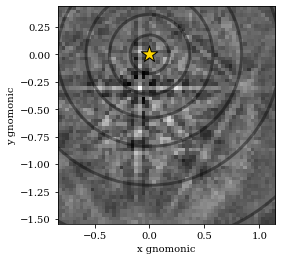

In [36]:
detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data, draw_gnomonic_circles=True)

## Generate dictionary of simulated patterns

Now we’re ready to generate our dictionary of simulated patterns by projecting parts of the master pattern onto our detector for all sampled orientations. The method assumes the crystal orientations are represented with respect to the EDAX TSL sample reference frame RD-TD-ND. For more details, see the [reference frame user guide](https://kikuchipy.org/en/stable/reference_frames.html).

So, generate a dictionary of simulated patterns using `MasterPattern.get_patterns()`

In [37]:
dynsim = mp.get_patterns(
    rotations=rot,
    detector=detector,
    energy=20,
    dtype_out=s.data.dtype,
    compute=True
)
dynsim

Creating a dictionary of (35083,) simulated patterns:
[########################################] | 100% Completed | 49.0s


<EBSD, title: , dimensions: (35083|60, 60)>

We've now generated the dictionary and read it into memory. We could instead have passed `compute=False`, which would have returned a `LazyEBSD` to be computed during the indexing run. This can sometimes be desirable.

Let's inspect a few of the simulated patterns to ensure they look alright by plotting them

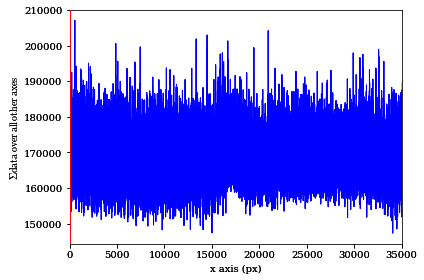

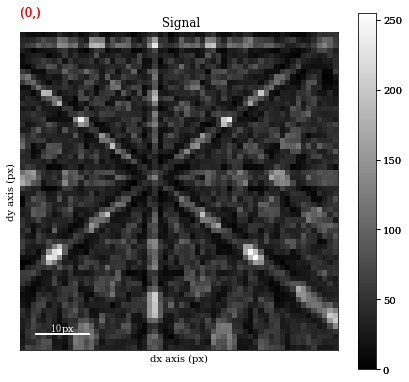

In [38]:
dynsim.plot()

## Perform dictionary indexing

Finally, let's match the simulated patterns to our experimental patterns, using the zero-mean normalized cross correlation (NCC) coefficient, which is the default similarity metric. We'll keep the 20 best matching orientations. A number of about 4125 * 35000 comparisons is quite small, which we can do in memory all at once. However, in cases where the number of comparisons are too big for our memory to handle, we can separate our simulated pattern data into slices. We'll use 20 slices here.

Let's perform `dictionary_indexing()`

In [39]:
xmap = s.dictionary_indexing(
    simulations=dynsim,
    metric="ncc",
    keep_n=20,
    n_slices=20
)

Matching ni patterns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31slice/s, mem=36.2%]


Inspect the returned [CrystalMap](https://orix.readthedocs.io/en/stable/crystal_map.html)

In [40]:
xmap

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

We can write the indexing results to file using one of orix' writers. orix' own HDF5 file format stores all results to in HDF5 file, while the .ang file writer only stores the best matching orientation

In [41]:
#io.save("di_results_ni1.h5", xmap)
#io.save("di_results_ni1.ang", xmap)

# <a id='6'>6. Inspect indexing results</a>

<a href='#toc'>Table of contents</a>

## Indexing maps

So far, orix cannot produce any orientation color maps, pole figures etc. This has to be done in other software, like [MTEX](https://mtex-toolbox.github.io/).

Here, we'll inspect the map of best matching scores and a so-called orientation similarity map, which compares the best matching orientations for each pattern to it's nearest neighbours.

Get the NCC map in the correct shape from the CrystalMap's `scores` property

In [42]:
ncc_map = xmap.scores[:, 0].reshape(*xmap.shape)

Get the `indexing.orientation_similarity_map()` using the full list of 20 best matches per pattern/point

In [43]:
os_map = kp.indexing.orientation_similarity_map(xmap)

Plot the maps using `Matplotlib`

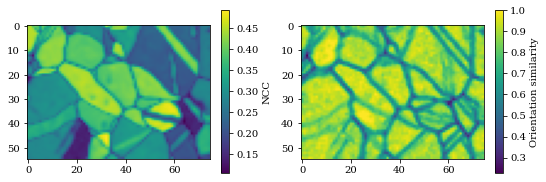

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))

im0 = ax[0].imshow(ncc_map)
fig.colorbar(im0, ax=ax[0], label="NCC")

im1 = ax[1].imshow(os_map)
fig.colorbar(im1, ax=ax[1], label="Orientation similarity");

## Compare to dynamical simulations

We can visually compare the experimental and best matching pattern side by side. First, we extract the best matching indices into the dictionary from the CrystalMap property `simulation_indices`

In [45]:
best_sim_idx = xmap.simulation_indices[:, 0]

Then we extract the simulated patterns corresponding to the indices, reshape the array to the same shape as the experimental data, and create an EBSD signal from it

In [46]:
best_patterns = dynsim.data[best_sim_idx].reshape(s.data.shape)
s_best = kp.signals.EBSD(best_patterns)
s_best

<EBSD, title: , dimensions: (75, 55|60, 60)>

Plot the experimental and simulated patterns (this is not easily done via Binder...) side by side using HyperSpy's `plot_signals()`, navigating in the NCC map

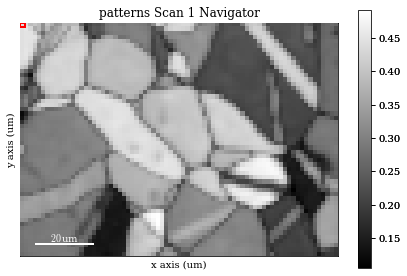

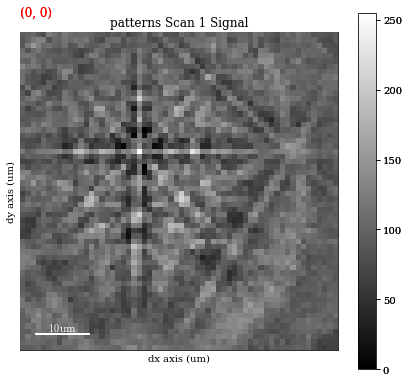

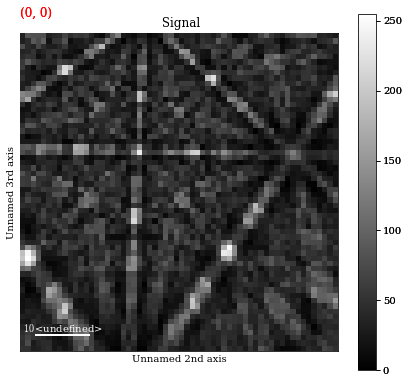

In [47]:
ncc_navigator = hs.signals.Signal2D(ncc_map)
hs.plot.plot_signals([s, s_best], navigator=ncc_navigator)

## Compare to geometrical simulations

We can can also add bands and zone axes from the best matching orientations as markers to the experimental EBSD data. The simulations are based on the work by Aimo Winkelmann in the supplementary material to the excellent tutorial paper by Britton et al. (2016) ([doi](https://doi.org/10.1016/j.matchar.2016.04.008)). See also the [geometrical EBSD simulations user guide](https://kikuchipy.org/en/stable/geometrical_ebsd_simulations.html) for more information than is given here.

**Note: At the moment, geometrical simulations can only be done for cubic crystals. (For those very interested, see [this pull request](https://github.com/pyxem/diffsims/pull/146) in diffsims.)**

First, we set up the relevant Kikuchi bands (the zone axes follows from these), namely $(hkl)$ = (111), (200), (220), and (311), using [diffsims'](https://diffsims.readthedocs.io) `ReciprocalLatticePoint`

In [48]:
rlp = ReciprocalLatticePoint(
    phase=phase, hkl=[[1, 1, 1], [2, 0, 0], [2, 2, 0], [3, 1, 1]]
)
rlp

ReciprocalLatticePoint (4,)
Phase: ni (m-3m)
[[1 1 1]
 [2 0 0]
 [2 2 0]
 [3 1 1]]

Get the symmetrically equivalent bands using `symmetrise()`

In [49]:
rlp2 = rlp.symmetrise()

Create an `EBSDSimulationGenerator` (remember to reshape the best matching rotations array to the experimental data shape!)

In [50]:
simgen = kp.generators.EBSDSimulationGenerator(
    detector=detector,
    phase=phase,
    rotations=xmap.rotations[:, 0].reshape(*xmap.shape)
)
simgen

EBSDSimulationGenerator (55, 75)
EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.421, 0.221, 0.505)
<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
Rotation (55, 75)

Generate bands and zone axes visible on the detector for the best matching orientations using `geometrical_simulation()`

In [51]:
geosim = simgen.geometrical_simulation(rlp2)
geosim

GeometricalEBSDSimulation (55, 75)
EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.421, 0.221, 0.505)
<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
KikuchiBand (55, 75|43)
Rotation (55, 75)

Use `as_markers()` to make HyperSpy markers from the geometrical simulations and add them to the experimental patterns with `add_marker()`

In [52]:
markers = geosim.as_markers(pc=False, zone_axes=False)
#del s.metadata.Markers
s.add_marker(markers, plot_marker=False, permanent=True)

Plot the experimental data, navigating in the NCC map

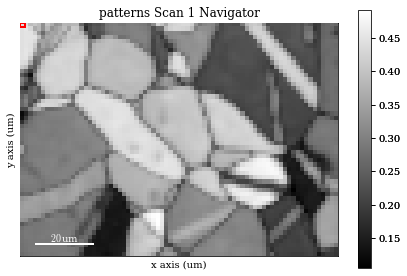

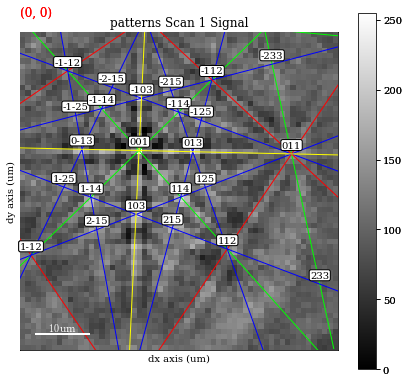

In [53]:
s.plot(navigator=ncc_navigator)

# <a id='7'>7. Going further</a>

<a href='#toc'>Table of contents</a>

This notebook includes the majority of the functionality kikuchipy has to offer. Want to do more with EBSD patterns in kikuchipy and the related pyxem family of packages (diffsims, orix)? If so, please submit a feature request on the GitHub repository's [issues pages](https://github.com/pyxem/kikuchipy/issues) or your code as a [pull request](https://github.com/pyxem/kikuchipy/pulls)! We also have a [GitHub discussions page](https://github.com/pyxem/kikuchipy/discussions) and a [Gitter channel](https://gitter.im/pyxem/kikuchipy). Feel free to just say hi!

Also, here is a short list of on-going work within the pyxem family of packages and other things that might be of interest:
* Orientation and/or PC refinement using reprojection of dynamically simulated patterns from a master pattern will be released as part of v0.5 of kikuchipy (see [this pull request](https://github.com/pyxem/kikuchipy/pull/387)).
* Coloring of orientations using the inverse pole figure and a given sample direction with orix is discussed in [this issue](https://github.com/pyxem/orix/issues/166) and [this issue](https://github.com/pyxem/orix/issues/169). The start of inverse pole figure functionality in orix is [this pull request](https://github.com/pyxem/orix/pull/213).
* There are a number of other great open-source packages useful for EBSD analysis out there. Some of them are listed [here](https://kikuchipy.org/en/stable/related_projects.html).